In [ ]:
#| default_exp layers

# Functional layers

> JaX/Flax implementation of functional layers.

In [ ]:
#| export
import jax
from typing import Any, Callable, Sequence, Union
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn
import optax
from einops import rearrange

from fxlayers.initializers import bounded_uniform

## Base layer

> First we'll define a base class that will be used by every other functional layer.

In [ ]:
class BaseFunctional(nn.Module):
    """Base functional layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))

        # x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        # kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        kernel = self.generate_kernel()

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        return outputs

    @staticmethod
    def generate_function(x, y, xmean, ymean, sigma, A=1):
        return A*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

## Gaussian layer

In [ ]:
#| export
class GaussianLayer(nn.Module):
    """Parametric gaussian layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=self.xmean),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
        return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, params["params"]["sigma"], params["params"]["A"], self.normalize_prob)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [ ]:
#| exporti
class GaussianLayerLogSigma(nn.Module):
    """Parametric gaussian layer that optimizes log(sigma) instead of sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
        return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), params["params"]["A"], self.normalize_prob)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaussianLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    sigma: (3,),
})


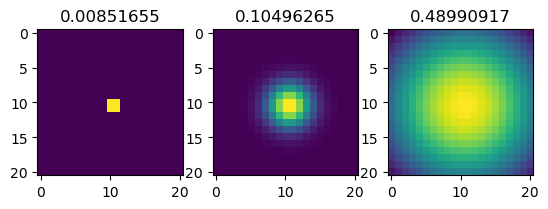

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigma"], axes):
    ax.imshow(k)
    ax.set_title(sigma)
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 154 ms, sys: 7.1 ms, total: 161 ms
Wall time: 267 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 18.3 ms, sys: 1.11 ms, total: 19.4 ms
Wall time: 15.8 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaussianLayer(features=3, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 46.98198318481445
Loss 100: 16.03009033203125
Loss 200: 8.65085506439209
Loss 300: 5.960490703582764
Loss 400: 4.6348466873168945
Loss 500: 3.844392776489258
Loss 600: 3.3134639263153076
Loss 700: 2.9298505783081055
Loss 800: 2.639446973800659
Loss 900: 2.4124348163604736
Loss 1000: 2.2307052612304688


The loss is going down, so everything looking good so far!

## Gabor layer

> We'll repeat the process but now with a Gabor functional form.

In [ ]:
#| export
class GaborLayer(nn.Module):
    """Parametric Gabor layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency

    normalize_prob: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        freq = self.param("freq",
                           nn.initializers.uniform(scale=self.fs/2),
                           (self.features*inputs.shape[-1],))
        logsigmax = self.param("logsigmax",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        logsigmay = self.param("logsigmay",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))        
        theta = self.param("theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        sigma_theta = self.param("sigma_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        rot_theta = self.param("rot_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigmax, sigmay = jnp.exp(logsigmax), jnp.exp(logsigmay)

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            # gabor_fn = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None))
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A, self.normalize_prob)
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A=1, normalize_prob=True):
        # ## Rotate the dominion
        # x = jnp.cos(rot_theta) * (x - xmean) - jnp.sin(rot_theta) * (y - ymean)
        # y = jnp.sin(rot_theta) * (x - xmean) + jnp.cos(rot_theta) * (y - ymean)
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1

        return A*A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)))

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"])
        # sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, params["freq"], params["theta"], params["sigma_theta"], params["rot_theta"], params["A"], self.normalize_prob)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, input_channels, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    freq: (3,),
    logsigmax: (3,),
    logsigmay: (3,),
    rot_theta: (3,),
    sigma_theta: (3,),
    theta: (3,),
})


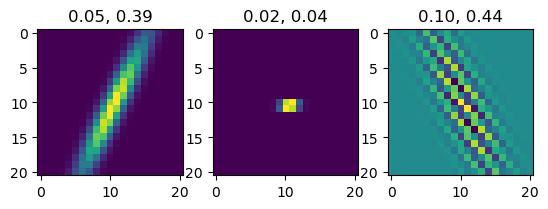

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel(params, c_in=3)
fig, axes = plt.subplots(1, 3)
# for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigmax"], params["sigmay"], axes):
for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"]), axes):
    ax.imshow(k)
    ax.set_title(f"{sigmax:.2f}, {sigmay:.2f}")
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 71.5 ms, sys: 20.9 ms, total: 92.4 ms
Wall time: 78.8 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 117 ms, sys: 16.3 ms, total: 133 ms
Wall time: 128 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
params

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})

In [ ]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)
print(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")
  # print(f"Loss {i}: {loss}")
  # print(params)

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})
Loss 0: 11759.92578125
Loss 100: 6.003411769866943
Loss 200: 3.3821327686309814
Loss 300: 2.540633201599121
Loss 400: 2.1371352672576904
Loss 500: 1.9039528369903564
Loss 600: 1.7531646490097046
Loss 700: 1.6479045152664185
Loss 800: 1.5702329874038696
Loss 900: 1.5104745626449585
Loss 1000: 1.4629968404769897


The loss is going down, so everything looking good so far!